In [1]:
import sys
sys.path.append('..')
import selex_dca, utils

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from utils import one_hot
import selex_dca
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

from matplotlib import cm

/Users/scrotti/Aptamer2025py/experiments/../selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N"]

In [67]:
from importlib import reload
reload(utils)
reload(callback)
reload(training)

<module 'training' from '/Users/scrotti/Aptamer2025py/experiments/../training.py'>

In [4]:
dtype = torch.float32
device = utils.best_device()

Selected device: cpu


In [6]:
round_id = round_ids[0]
sequences =  utils.sequences_from_file(experiment_id, round_id, device)

In [7]:
n_sequences = len(sequences)
sequences_unique, counts = torch.unique(sequences, dim=0, return_counts=True)

In [68]:
utils.log_multinomial(counts)

146028236.375

In [69]:
N = 10
n = torch.tensor([2, 3, 4, 1, 0])
probs = torch.rand(len(n))
probs /= probs.sum()

In [70]:
d = torch.distributions.multinomial.Multinomial(N, probs)
d.log_prob(n)

tensor(-10.6544)

In [71]:
def log_prob(N, probs, n):
    lM = utils.log_multinomial(n)
    lp = (n * torch.log(probs)).sum()
    return lM + lp

In [72]:
log_prob(N, probs, n)

tensor(-10.6544)

In [61]:
N = n_sequences
n = counts
logNfact = logfactorial(N)
lognfact = logfactorial(n).sum().item()
logmult = logNfact - lognfact
logNfact, lognfact, logmult

(147366288.0, 1338051.625, 146028236.375)

In [ ]:
def sequences_unique_and_counts(sequences): 
    
    
    return seq

In [ ]:
sequences = [utils.sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [5]:
sequences_oh = [one_hot(seq).to(dtype=dtype) for seq in sequences]

In [280]:
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh]).to(device)
fi0, _, _ = utils.frequences_from_sequences_oh(sequences_oh[0])

In [281]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")

selected_modes = torch.BoolTensor(
    [[1], [1]]
)

In [282]:
L, q = sequences_oh[0][0].shape

k = torch.zeros(L, q, dtype=dtype)
# k = torch.log(fi0)
h = torch.zeros(L, q, dtype=dtype)
J = torch.zeros(L, q, L, q, dtype=dtype)
# J = utils.rand_coupling_matrix(L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)

ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes).to(device)

In [283]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

In [284]:
n_chains = 10**5
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype, device=device)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype, device=device)

In [285]:
checkpoint_filename = experiment_id
checkpoint_every = 500
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback(), 
             callback.CheckpointCallback(save_every=checkpoint_every, filename=checkpoint_filename),
             callback.ParamsCallback(save_every=100)]

In [ ]:
n_sweeps = 10
lr = 0.01
max_epochs = 2*10**3

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs,
               lr=lr, callbacks=callbacks, log_weights=log_weights)

 0.00%[                                                                                                       …

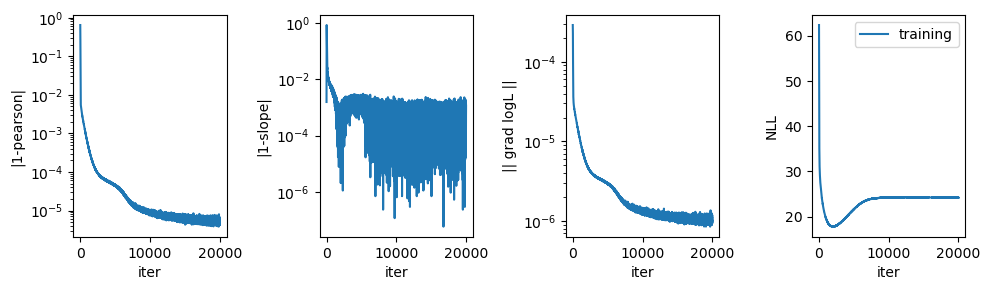

In [287]:
callbacks[0].plot();

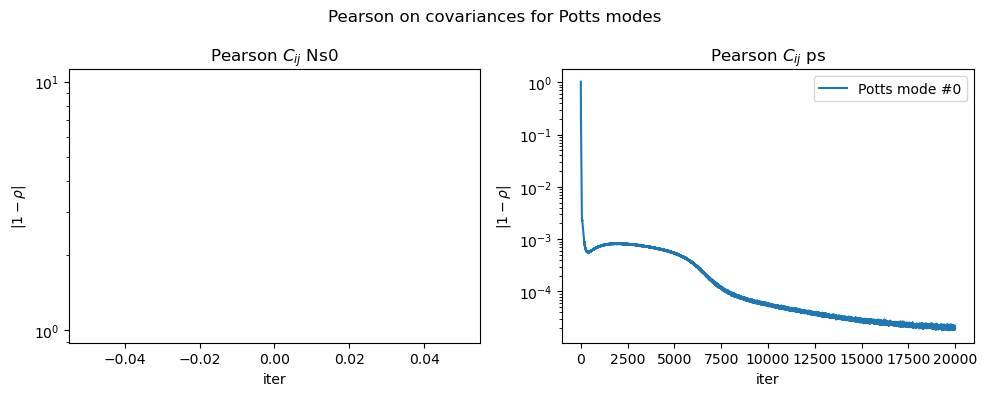

In [288]:
callbacks[1].plot();

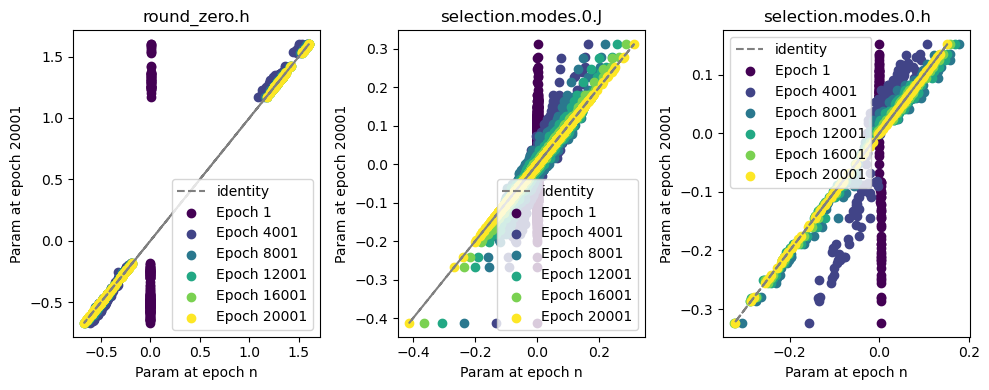

In [292]:
callbacks[-1].plot(plot_every=40);

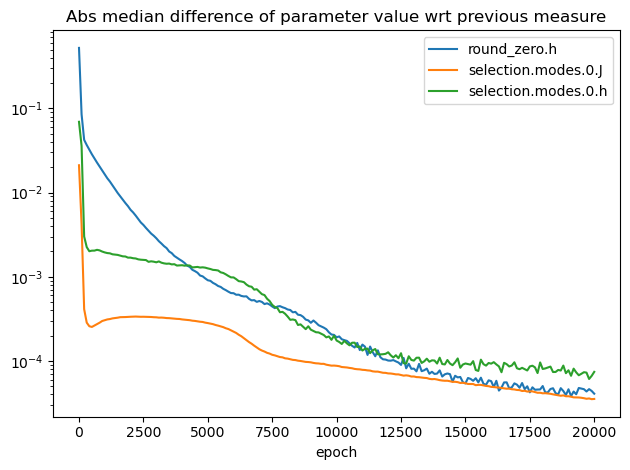

In [290]:
callbacks[-1].plot_diff();

<IPython.core.display.Latex object>

Multi-round


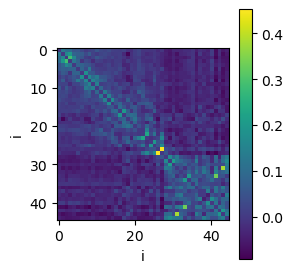

In [293]:
from IPython.display import display, Latex

potts_zerosum = potts.set_zerosum_gauge()
J = potts_zerosum.J.detach()
h = potts_zerosum.h.detach()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))
print('Multi-round')

In [ ]:
torch.save(model, f'saved/{experiment_id}.pt')

In [294]:
cps = training.load_checkpoints(checkpoint_filename)

Loaded 40 files.


In [296]:
Fs = []
Js = []
hs = []
for n in range(len(cps)):
    cp = cps[n]
    model_ = cp['model']
    potts_zerosum = model_.selection.modes[0].set_zerosum_gauge()
    J = potts_zerosum.J.detach()
    h = potts_zerosum.h.detach()
    F = selex_dca.get_contact_map(J)
    Fs.append(F)
    Js.append(J)
    hs.append(h)

/tmp/ipykernel_2272747/3192101322.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  pl, ax = plt.subplots(figsize=(3,3))


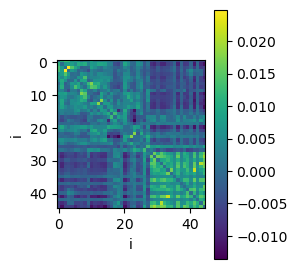

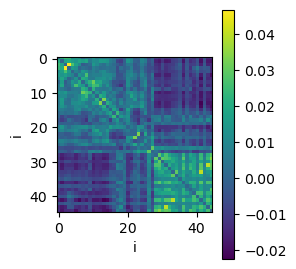

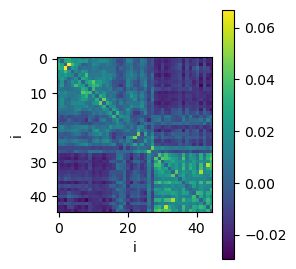

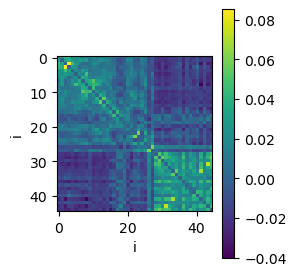

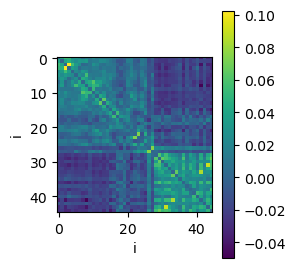

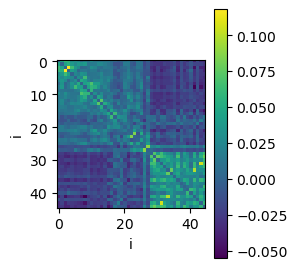

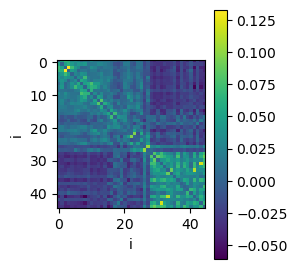

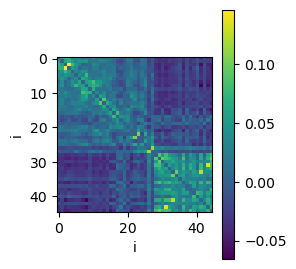

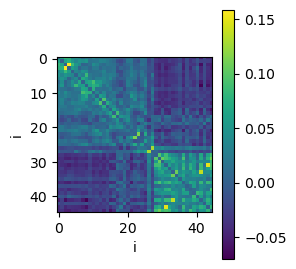

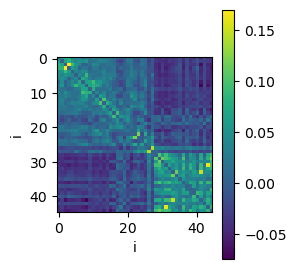

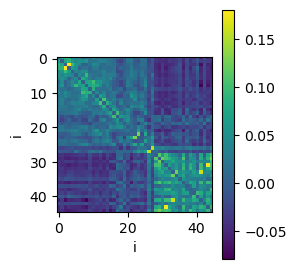

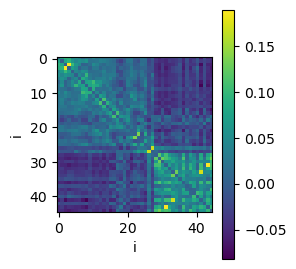

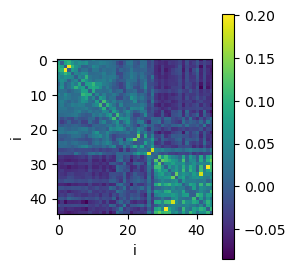

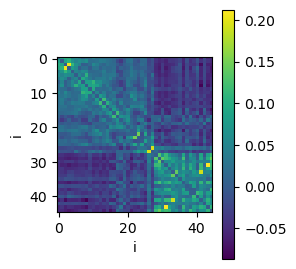

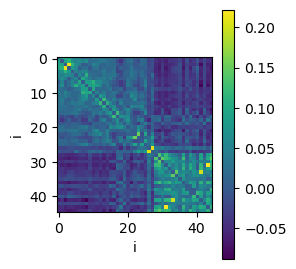

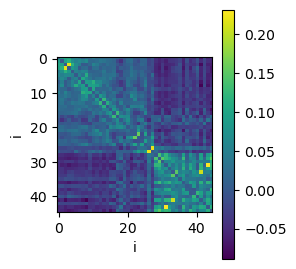

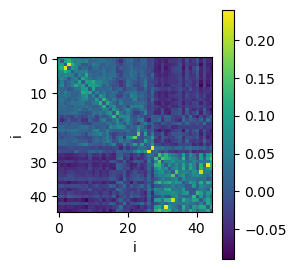

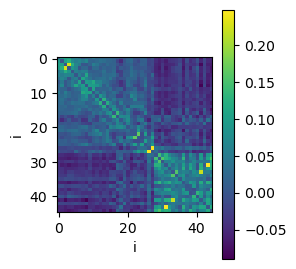

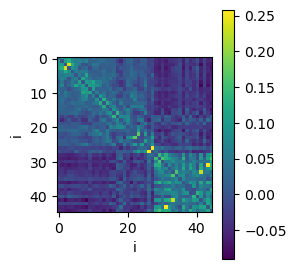

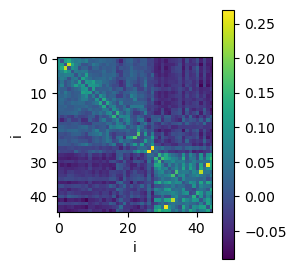

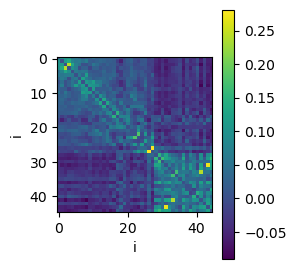

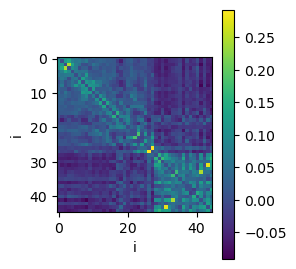

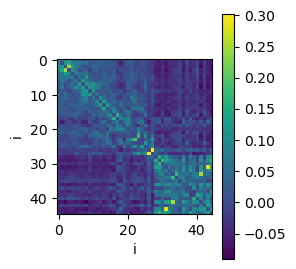

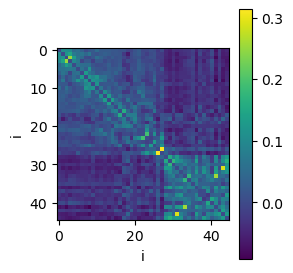

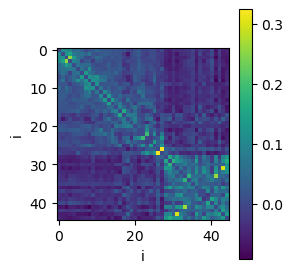

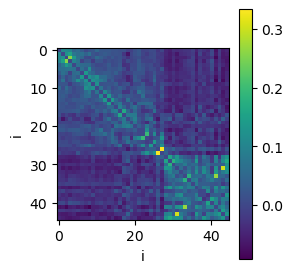

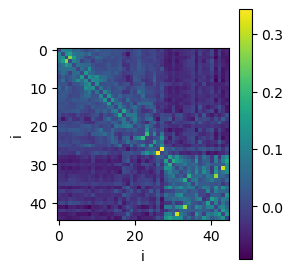

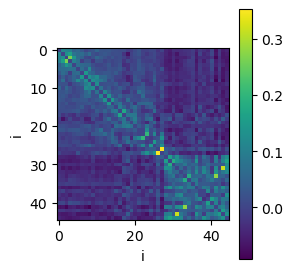

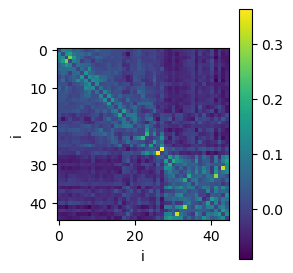

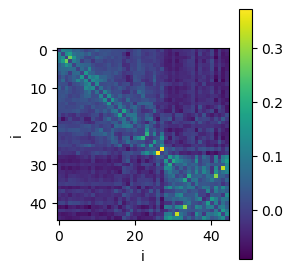

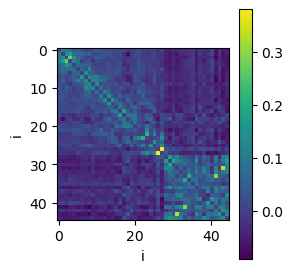

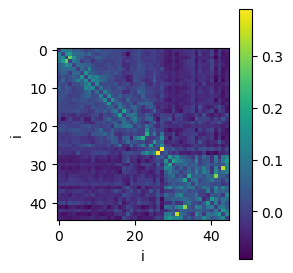

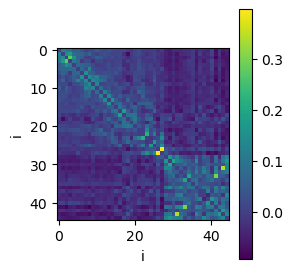

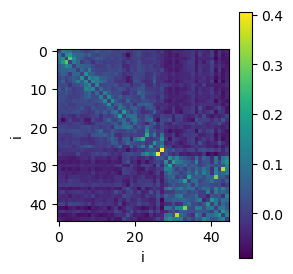

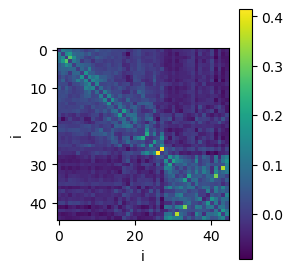

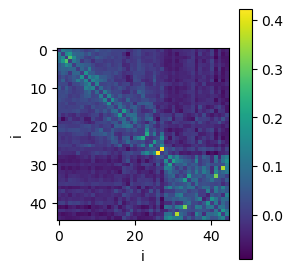

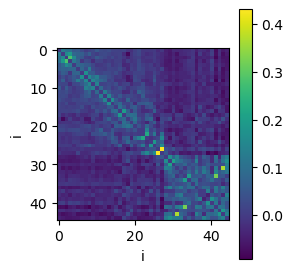

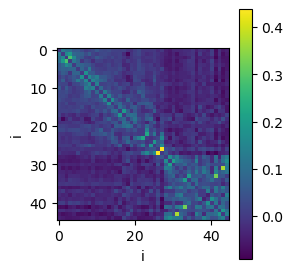

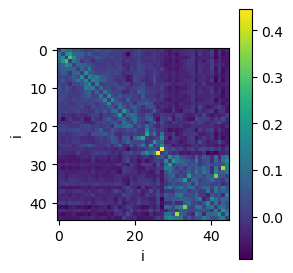

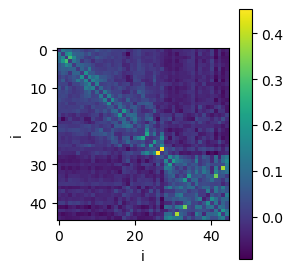

In [297]:
for n in range(len(cps)):
    pl, ax = plt.subplots(figsize=(3,3))
    im = ax.imshow(Fs[n])
    ax.set_xlabel("i"); ax.set_ylabel("i")
    plt.colorbar(im)
    plt.tight_layout()

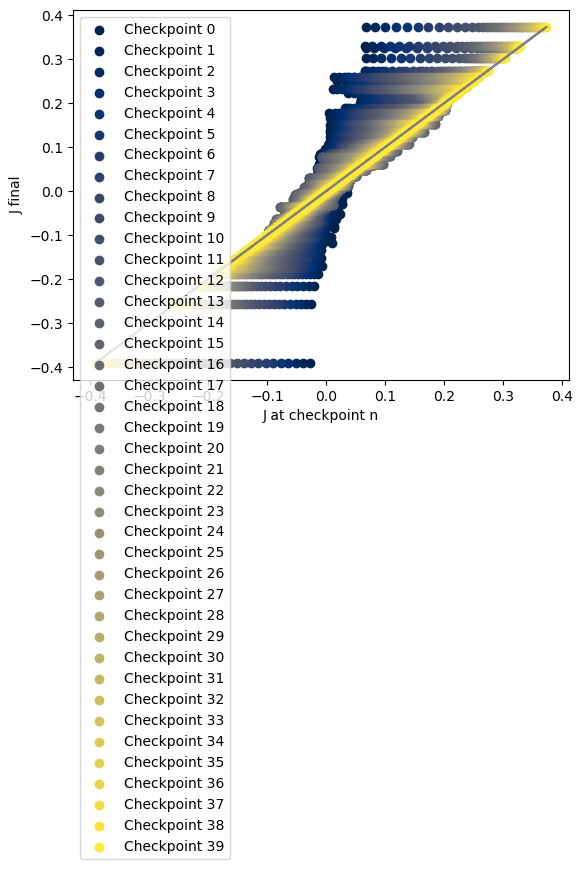

In [298]:
cgrad = [cm.cividis(x) for x in np.linspace(0, 1, len(cps))]
for n in range(len(cps)):
    plt.scatter(utils.off_diagonal_terms(Js[n]), utils.off_diagonal_terms(Js[-1]), 
                label=f'Checkpoint {n}', color=cgrad[n])

plt.plot(Js[-1].reshape(-1), Js[-1].reshape(-1), color='gray')
plt.xlabel('J at checkpoint n')
plt.ylabel('J final')
plt.legend()

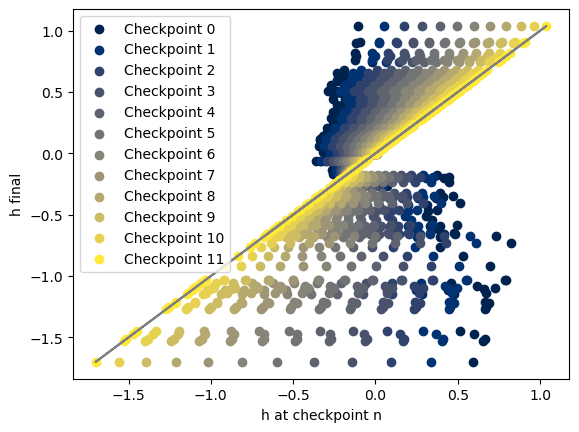

In [229]:
for n in range(len(cps)):
    plt.scatter(hs[n], hs[-1], label=f'Checkpoint {n}', color=cgrad[n])

plt.plot(hs[-1].reshape(-1), hs[-1].reshape(-1), color='gray')
plt.xlabel('h at checkpoint n')
plt.ylabel('h final')
plt.legend()